In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG16
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

from keras.utils.vis_utils import plot_model

from PIL import Image
import warnings
warnings.filterwarnings("ignore")
random.seed(45)

print(tf.__version__)

2.8.0


In [ ]:
import glob
import os
from tqdm import tqdm
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

**LOAD IMAGE DATA AND UNDERSTANDING SOME PROPERTIES OF IMAGE**

In [ ]:
def image_properties(path):
    for img in random.sample(os.listdir(path),1):
        print('Image name =',img)
        image = cv.imread(os.path.join(path, img),cv.IMREAD_COLOR)
        break
        
    return image

Image name = 104277.jpg
The dimensions are 640 pixels height and 480 pixels width
The maximum pixel value is 255.00
The minimum pixel value is 0.00
The mean value of the pixels is 98.83
The standard deviation is 73.32


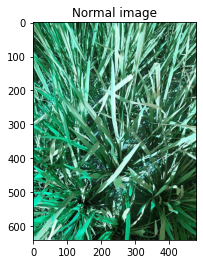

In [ ]:
path = '/content/drive/MyDrive/train_images/normal'

image = image_properties(path)
plt.imshow(image)
plt.title('Normal image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.2f}")
print(f"The minimum pixel value is {image.min():.2f}")
print(f"The mean value of the pixels is {image.mean():.2f}")
print(f"The standard deviation is {image.std():.2f}")

**Loading a dataset**

In [ ]:
batch_size = 64
img_height = 256
img_width =  256

data_dir = '/content/drive/MyDrive/train_images'

**Image Data-Generator**

**Data Normalization And Data Augmentation**

In [ ]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

**Training Dataset (70%)**

In [ ]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


**Testing Dataset (30%)**

In [ ]:
valid_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


**Class Lables**

In [ ]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


**Displaying a 9 Random images form dataset**

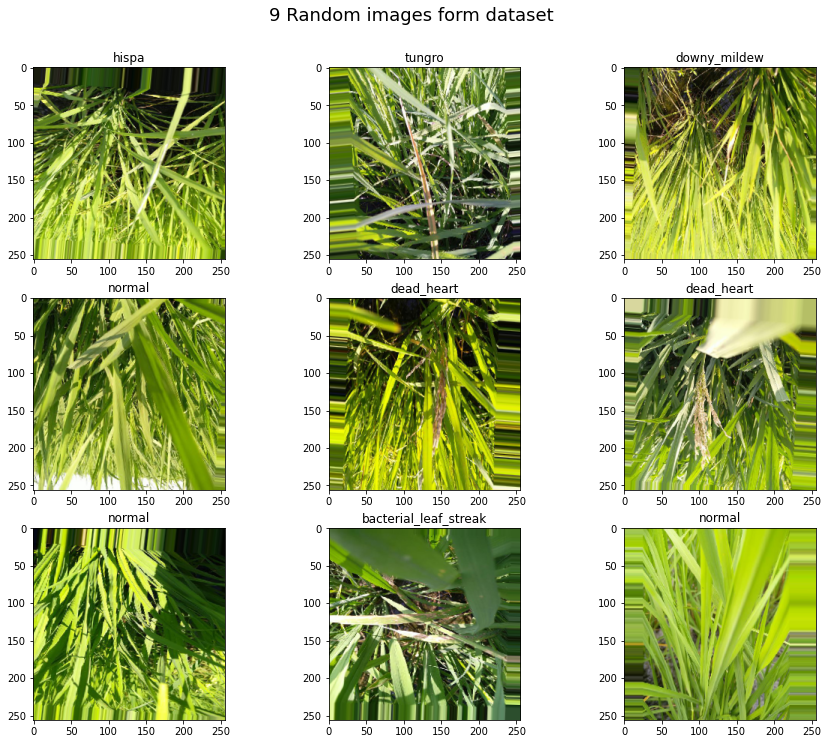

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("9 Random images form dataset", fontsize=18, y=0.95)

for i in range(1,10):
    plt.subplot(3,3,i)
    img, label = train_gen.next()
    plt.title(list(train_gen.class_indices.keys())[np.argmax(label)])
    plt.imshow(img[0])

**CNN Model**

In [ ]:
num_classes = 10
input_shape = (batch_size,256,256,3)

In [ ]:
model = None
model = tf.keras.Sequential([
                             
        tf.keras.layers.Conv2D(16, (3,3), activation='relu' ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (64, 30, 30, 64)         0

**CallBacks**

In [ ]:
# terminate if loss was NaN
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [ ]:
# save model after every epoch if the validation accuracy improves from previous epoch
filepath = '/content/drive/MyDrive/paddy_models/model_vgg_new.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

In [ ]:
# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=1,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)]
)

In [ ]:
history = model.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/20
114/114 [==============================] - ETA: 0s - loss: 2.0848 - categorical_accuracy: 0.2393
Epoch 1: val_categorical_accuracy improved from -inf to 0.29561, saving model to /content/drive/MyDrive/paddy_models/model_base.hdf5
114/114 [==============================] - 223s 2s/step - loss: 2.0848 - categorical_accuracy: 0.2393 - val_loss: 2.0083 - val_categorical_accuracy: 0.2956 - lr: 3.0000e-04
Epoch 2/20
114/114 [==============================] - ETA: 0s - loss: 1.8647 - categorical_accuracy: 0.3384
Epoch 2: val_categorical_accuracy improved from 0.29561 to 0.35043, saving model to /content/drive/MyDrive/paddy_models/model_base.hdf5
114/114 [==============================] - 226s 2s/step - loss: 1.8647 - categorical_accuracy: 0.3384 - val_loss: 1.8094 - val_categorical_accuracy: 0.3504 - lr: 3.0000e-04
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 1.7253 - categorical_accuracy: 0.3935
Epoch 3: val_categorical_accuracy improved from 0.35043 to 0.

**training vs validation loss**

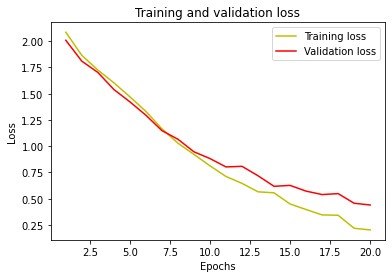

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Training Accuracy Vs Validation Accuracy**

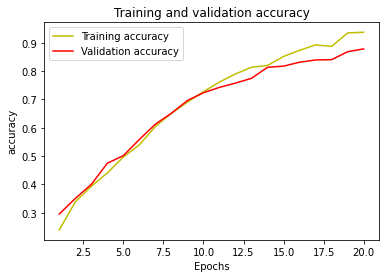

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_gen)

49/49 [==============================] - 62s 1s/step - loss: 0.4585 - categorical_accuracy: 0.8759


In [ ]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.8759217858314514


**MobileNetV2**

In [ ]:
model_mobile_net = MobileNetV2(include_top = False, input_shape = (256,256,3), weights = 'imagenet')

model_mobile_net.trainable = True

inputs = Input(shape=(256,256,3))
main = model_mobile_net(inputs, training = True)

x = layers.Flatten()(main)
x = layers.Dense(256, 'relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax', name= 'outputs')(x)

model_mobile_net = Model(inputs= [inputs], outputs= [outputs])


model_mobile_net.compile(optimizer=optimizers.Adam(3e-4), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)], 
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

model_mobile_net.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 256)               20971776  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                

In [ ]:
history = model_mobile_net.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/20
114/114 [==============================] - ETA: 0s - loss: 2.0846 - categorical_accuracy: 0.3901
Epoch 1: val_categorical_accuracy improved from -inf to 0.54793, saving model to /content/drive/MyDrive/paddy_models/model_mobile_net.hdf5
114/114 [==============================] - 216s 2s/step - loss: 2.0846 - categorical_accuracy: 0.3901 - val_loss: 1.7394 - val_categorical_accuracy: 0.5479 - lr: 3.0000e-04
Epoch 2/20
114/114 [==============================] - ETA: 0s - loss: 1.4211 - categorical_accuracy: 0.6231
Epoch 2: val_categorical_accuracy improved from 0.54793 to 0.67201, saving model to /content/drive/MyDrive/paddy_models/model_mobile_net.hdf5
114/114 [==============================] - 211s 2s/step - loss: 1.4211 - categorical_accuracy: 0.6231 - val_loss: 1.3521 - val_categorical_accuracy: 0.6720 - lr: 3.0000e-04
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 1.1709 - categorical_accuracy: 0.7396
Epoch 3: val_categorical_accuracy improved from 0

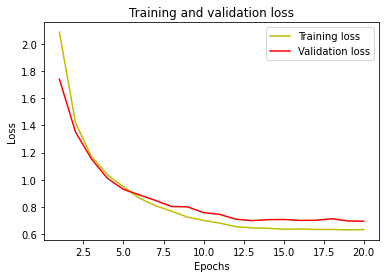

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

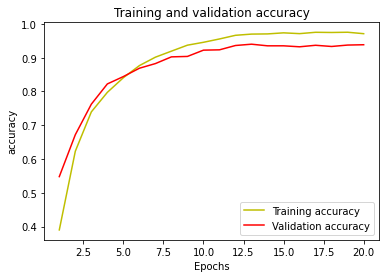

In [ ]:
acc = model_mobile_net.history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model_mobile_net.evaluate(valid_gen)

49/49 [==============================] - 63s 1s/step - loss: 0.6994 - categorical_accuracy: 0.9378


In [ ]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.9378005862236023


**InceptionV3**

In [ ]:
model_inception = None
model_inception = InceptionV3(include_top = False, input_shape = (256,256,3), weights = 'imagenet')

model_inception.trainable = True

inputs = Input(shape=(256,256,3))
main = model_inception(inputs, training = True)

x = layers.Flatten()(main)
x = layers.Dense(256, 'relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax', name= 'outputs')(x)

model_inception = Model(inputs= [inputs], outputs= [outputs])


model_inception.compile(optimizer=optimizers.Adam(3e-4), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)], 
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

model_inception.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               18874624  
                                                                 
 batch_normalization_95 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 outputs (Dense)             (None, 10)                2570 

In [ ]:
history = model_inception.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/20
114/114 [==============================] - ETA: 0s - loss: 2.2923 - categorical_accuracy: 0.2910
Epoch 1: val_categorical_accuracy improved from -inf to 0.49535, saving model to /content/drive/MyDrive/paddy_models/model_inception.hdf5
114/114 [==============================] - 236s 2s/step - loss: 2.2923 - categorical_accuracy: 0.2910 - val_loss: 1.8702 - val_categorical_accuracy: 0.4954 - lr: 3.0000e-04
Epoch 2/20
114/114 [==============================] - ETA: 0s - loss: 1.4924 - categorical_accuracy: 0.6251
Epoch 2: val_categorical_accuracy improved from 0.49535 to 0.68035, saving model to /content/drive/MyDrive/paddy_models/model_inception.hdf5
114/114 [==============================] - 214s 2s/step - loss: 1.4924 - categorical_accuracy: 0.6251 - val_loss: 1.4191 - val_categorical_accuracy: 0.6803 - lr: 3.0000e-04
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 1.1482 - categorical_accuracy: 0.7656
Epoch 3: val_categorical_accuracy improved from 0.6

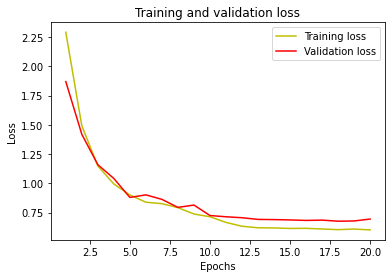

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

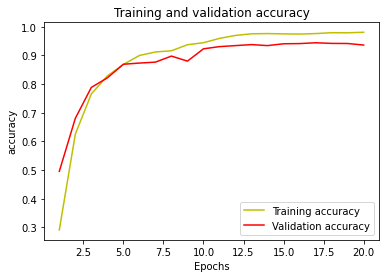

In [ ]:
acc = model_inception.history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model_inception.evaluate(valid_gen)

49/49 [==============================] - 62s 1s/step - loss: 0.6786 - categorical_accuracy: 0.9416


In [ ]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.9416479468345642


**Vision Transformer (ViT)**

#### REF: `https://keras.io/examples/vision/image_classification_with_vision_transformer/`

In [ ]:
# loads an image and convert them to numpy array
def load_images(paths):

  data = []
  labels = []
  i = 0
  for label, path in tqdm(enumerate(paths)):
    for img_path in os.listdir(path):
      image = np.array(Image.open(os.path.join(path,img_path)).convert('RGB').resize((256,256)))
      data.append(image)
      labels.append(label)

  return np.array(data), np.asarray(labels)

In [ ]:
images, labels = load_images(glob.glob('/content/drive/MyDrive/train_images/*')) 

10it [02:10, 13.08s/it]


**Train Test Split (70:30)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels.reshape(-1,1), test_size=0.33, random_state=42)

In [ ]:
num_classes = 10
input_shape = (256, 256, 3)

**Configure the hyperparameters**

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

**Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

**multilayer perceptron (MLP)**

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**Implementing patch creation as a layer**

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


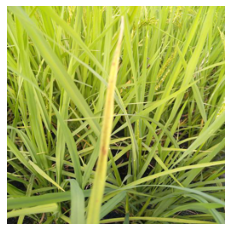

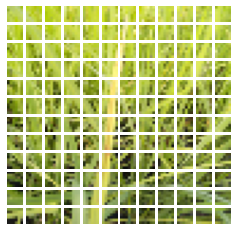

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Implementing the patch encoding layer**

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

**ViT Model**

In [ ]:
def create_vit_classifier():
    
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ]
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.3
    )

    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
153/153 [==============================] - 25s 83ms/step - loss: 2.9005 - accuracy: 0.2094 - val_loss: 2.0026 - val_accuracy: 0.2949
Epoch 2/100
153/153 [==============================] - 11s 72ms/step - loss: 2.0767 - accuracy: 0.2684 - val_loss: 1.8539 - val_accuracy: 0.3456
Epoch 3/100
153/153 [==============================] - 11s 73ms/step - loss: 1.9750 - accuracy: 0.3107 - val_loss: 1.7863 - val_accuracy: 0.3580
Epoch 4/100
153/153 [==============================] - 11s 72ms/step - loss: 1.8874 - accuracy: 0.3418 - val_loss: 1.7401 - val_accuracy: 0.3805
Epoch 5/100
153/153 [==============================] - 11s 72ms/step - loss: 1.8425 - accuracy: 0.3551 - val_loss: 1.6930 - val_accuracy: 0.4001
Epoch 6/100
153/153 [==============================] - 11s 72ms/step - loss: 1.7331 - accuracy: 0.4004 - val_loss: 1.5017 - val_accuracy: 0.4799
Epoch 7/100
153/153 [==============================] - 11s 72ms/step - loss: 1.6412 - accuracy: 0.4334 - val_loss: 1.4469 - val_ac

In [ ]:
#vit_classifier.save_weights('/content/drive/MyDrive/paddy_models/vit.hdf5')

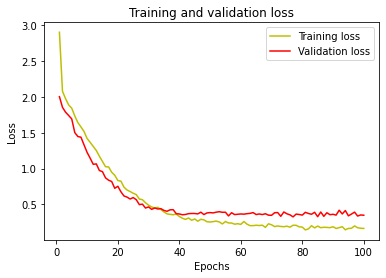

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

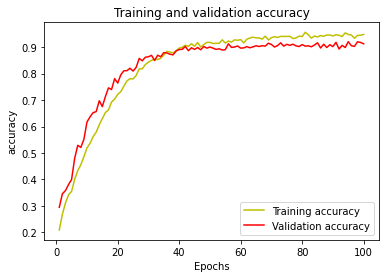

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()